In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib notebook

from custom_trading_env import TradingEnv
import DQNTradingAgent.dqn_agent as dqn_agent

device = dqn_agent.device
dqn_agent.set_device(device)

from tqdm import tqdm, tnrange
import pickle

In [2]:
n_action_intervals = 5

sample_len   = 480
obs_data_len = 192
step_len     = 1
fee          = 0.0
sell_at_end  = False

df = pd.read_hdf('dataset/binance_data_train.h5', 'STW')
df.fillna(method='ffill', inplace=True)

In [3]:
def draw_integrated_gradient(env_name):
#     hyperparam_path = f"./saves/transfer/{env_name}/1/hyperparams.pth"
#     statedict_path  = f"./saves/transfer/{env_name}/1/TradingGym_Rainbow_400.pth"
    hyperparam_path = f"./saves/Original/2/hyperparams.pth"
    statedict_path  = f"./saves/Original/2/TradingGym_Rainbow_600.pth"
    
    class args():
        def __init__(self, env_name):
            self.environment = env_name

    args = args(env_name)
    env = TradingEnv(custom_args=args, env_id='custom_trading_env', obs_data_len=obs_data_len, step_len=step_len, sample_len=sample_len,
                         df=df, fee=fee, initial_budget=1, n_action_intervals=n_action_intervals, deal_col_name='c',
                         sell_at_end=sell_at_end,
                         feature_names=['o', 'h','l','c','v',
                                        'num_trades', 'taker_base_vol'])

    agent = dqn_agent.Agent(action_size=2 * n_action_intervals + 1,
                            obs_len=obs_data_len,
                            num_features=env.reset().shape[-1],
                            **torch.load(hyperparam_path))

    agent.qnetwork_local.load_state_dict(torch.load(statedict_path, map_location=device))
    agent.qnetwork_local.eval()
    for param in agent.qnetwork_local.parameters():
        param.requires_grad_(False)


    def integrated_gradient(input_data, baseline_data, action, n_steps):
        assert input_data.shape == baseline_data.shape, "the shape of `input_data` and `baseline_data` must match."\
                                                        "(Given shapes: {}, {})".format(input_data.shape, baseline_data.shape)

        input_data    = input_data.view(1, *input_data.shape[-2:])
        baseline_data = baseline_data.view(1, *baseline_data.shape[-2:])

        diff      = input_data.data - baseline_data.data
        increment = diff / n_steps

        x = baseline_data.data.clone()
        x.requires_grad_(True)

        for i in tnrange(n_steps):
            z_probs = F.softmax(agent.qnetwork_local(x)[0, action], dim=0)
            q = agent.supports.mul(z_probs).sum()
            q.backward()
            x.data.add_(increment)

        x.grad.div_(n_steps)

        return (x.grad).squeeze(0)   

    next_state = env.reset()
#     fee_rate_list = []
    for i in tnrange(100):
        state = next_state
        action = int(agent.act(state, eps=0.))
        next_state, _, done, _, = env.step(action)
#         fee_rate_list.append(fee_rate)
        if done:
            break
    input_data    = torch.from_numpy(state).float()
    baseline_data = torch.zeros_like(input_data)
    importances_list = [integrated_gradient(input_data, baseline_data, action=act, n_steps=100) for act in tnrange(2*n_action_intervals+1, desc = f"{env_name}")]
    concat = torch.stack(importances_list)
    concat_sum = concat.sum(dim= 1)
    imp_sum = concat_sum.t().flip([0])

    fig, ax = plt.subplots(1, 1, figsize=(3, 12))

    img = ax.pcolormesh(imp_sum, cmap='viridis', edgecolors='black')
    fig.colorbar(img)

    ax.set_title(f'Approximate Feature Importance {env_name}')

    ax.set_ylabel('Features')
    ax.set_yticks(np.arange(importances_list[0].shape[1]) + 0.5)
    ax.set_yticklabels(['o', 'h','l','c','v', 'num_trades', 'taker_buy_base_vol',
                        'fee_rate'][::-1])
    ax.set_xticks(np.arange(11)+0.5)
    ax.set_xticklabels(list(map(str,range(11))))
    ax.set_xlabel('Actions')

#     ax[1].set_title(f'Fee rate change {env_name}')
#     ax[1].set_ylabel("Fee rate")
#     ax[1].set_xlabel("steps")
#     ax[1].plot(fee_rate_list)
    plt.show()
    plt.savefig(f"saves/figs/{env_name}.png")
    
#     if not os.path.exists("saves/fees_pkl/"):
#         os.makedirs("saves/fees_pkl/")
#     with open(f"saves/fees_pkl/{env_name}.pkl",'wb') as f:
#         pickle.dump(fee_rate, f)

In [4]:
os.listdir("saves/Original/2")

['scores.pth',
 'TradingGym_Rainbow_600.pth',
 'TradingGym_Rainbow_200.pth',
 'hyperparams.pth',
 'TradingGym_Rainbow_400.pth']

In [5]:
env_list = [
 'macd',
 'stochastic',
 'rsi',
 'bollinger',
'0.000','0.003',
 '0.005',]

[2019-09-06 14:40:52,249] Making new env: custom_trading_env
/home/jeffrey/Binanace_trading_simulation/agent/AttentionPositionalEncoding/custom_trading_env.py:99: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self.price = self.df_sample[self.price_name].as_matrix()
/home/jeffrey/Binanace_trading_simulation/agent/AttentionPositionalEncoding/custom_trading_env.py:101: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self.obs_features = self.df_sample[self.using_feature].as_matrix()


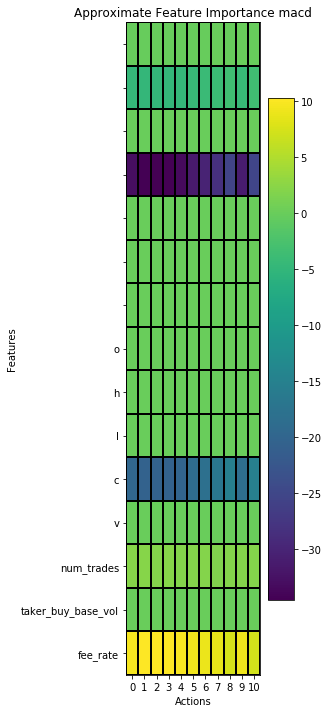

[2019-09-06 14:42:20,047] Making new env: custom_trading_env


<Figure size 432x288 with 0 Axes>

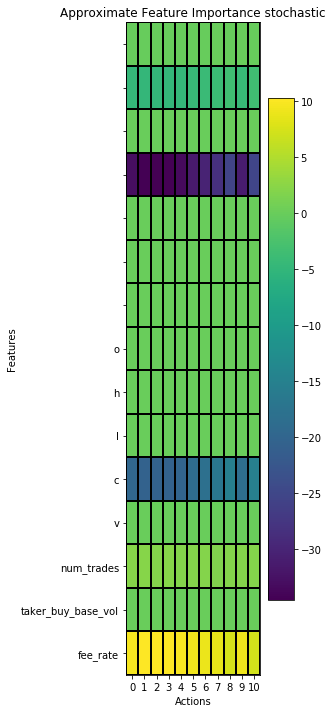

[2019-09-06 14:43:50,837] Making new env: custom_trading_env


<Figure size 432x288 with 0 Axes>

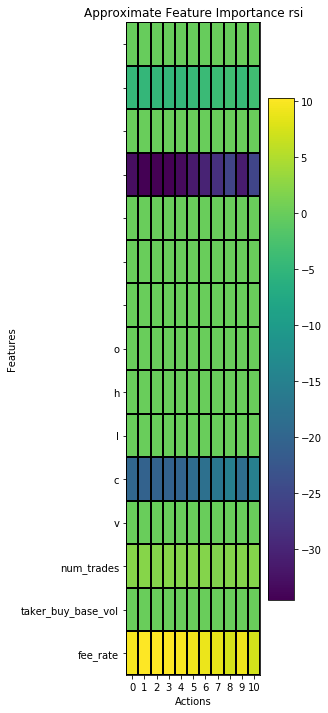

[2019-09-06 14:45:15,396] Making new env: custom_trading_env


KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [6]:
for env_name in env_list:
    draw_integrated_gradient(env_name)